### Further clean RISK variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, print_percentile
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

18

In [6]:
# df_list = drop_temp_columns(df_list)

In [7]:
START = time.time()

### Read Data

In [8]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/risk.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/risk.parquet")

Shape of data: (5531451, 30)
Shape of data: (11363762, 30)
CPU times: user 15.8 s, sys: 25.9 s, total: 41.7 s
Wall time: 22.3 s


In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 5.36 s, sys: 1.52 s, total: 6.88 s
Wall time: 6.89 s


In [10]:
del test

In [11]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 1.75 s, sys: 1.67 s, total: 3.42 s
Wall time: 5.28 s


In [12]:
train.shape, public_test.shape, private_test.shape

((5531451, 31), (5719469, 30), (5644293, 30))

In [13]:
print(sorted(get_cols(train, ["R_"])))

['R_1', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_2', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9']


In [14]:
train["target"].mean()

0.24909720794778803

In [15]:
df_list = [train, public_test, private_test]

### R_1 (Done Integer)

In [16]:
# plot_target_check(train, "R_1", q=50, use_raw_bin=True)

In [17]:
%%time
df_list = round_dfs(df_list, col="R_1", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.2231
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0946
CPU times: user 3.71 s, sys: 1.84 s, total: 5.55 s
Wall time: 7.25 s


In [18]:
for df in df_list:
    df["R_1"] = (df["R_1"] * 4).round(0)

In [172]:
print_percentile(df_list, "R_1", 99.98)

99.98th percentile:
train : 8.0
public test : 8.0
private test : 8.0


In [174]:
for df in df_list:
    df = clip_col(df, "R_1", top_value=8, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


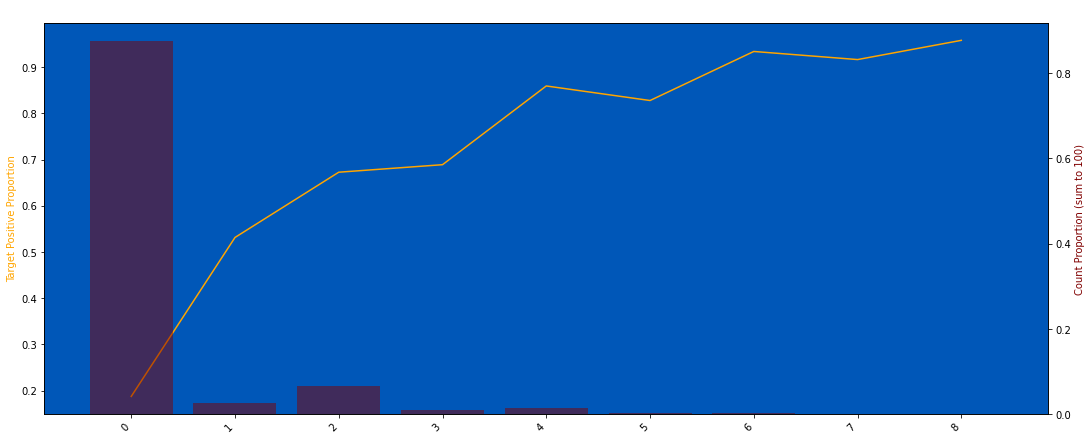

In [175]:
plot_target_check(train, "R_1", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [177]:
# plot_train_test_distribution(df_list, "R_1", nunique_thr=10000, without_drop_tail=True)

### R_2 (Done Binary)

In [21]:
# plot_target_check(train, "R_2", q=50, use_raw_bin=True)

In [22]:
%%time
df_list = round_dfs(df_list, col="R_2", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0000
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 3.65 s, sys: 1.81 s, total: 5.46 s
Wall time: 7.13 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


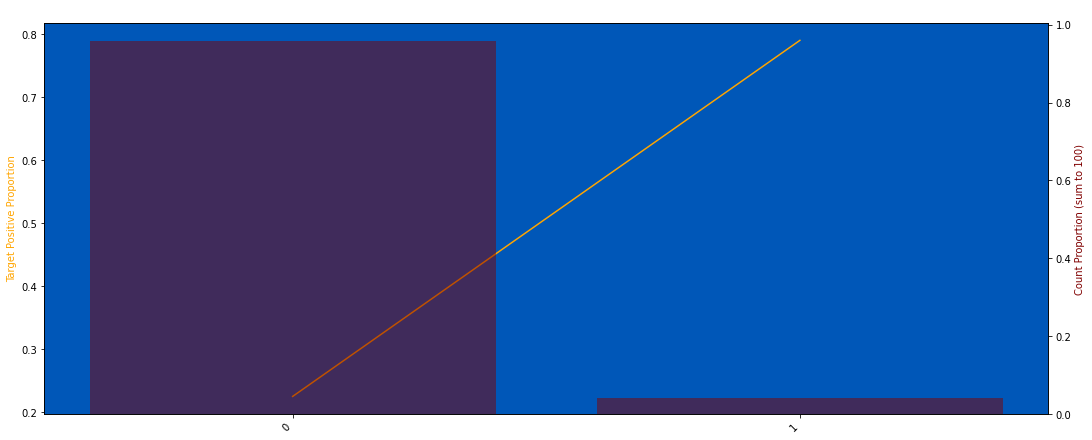

In [179]:
plot_target_check(train, "R_2", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [178]:
# plot_train_test_distribution(df_list, "R_2", nunique_thr=100)

### R_3 (Done Integer)

In [25]:
# plot_target_check(train, "R_3", q=50, use_raw_bin=True)

In [26]:
%%time
df_list = round_dfs(df_list, col="R_3", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0232
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0163
CPU times: user 3.62 s, sys: 1.79 s, total: 5.41 s
Wall time: 7.14 s


In [27]:
describe_all(df_list, "R_3")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1158,0.1137,0.1077
std,0.2105,0.2049,0.1928
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.2000,0.2000,0.1000
max,11.6000,9.9000,7.4000
null_proportion,0.0000,0.0000,0.0000


In [28]:
print_percentile(df_list, "R_3", 99.9)

99.9th percentile:
train : 2.0
public test : 1.8
private test : 1.7


In [29]:
for df in df_list:
    df = clip_col(df, "R_3", top_value=2, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


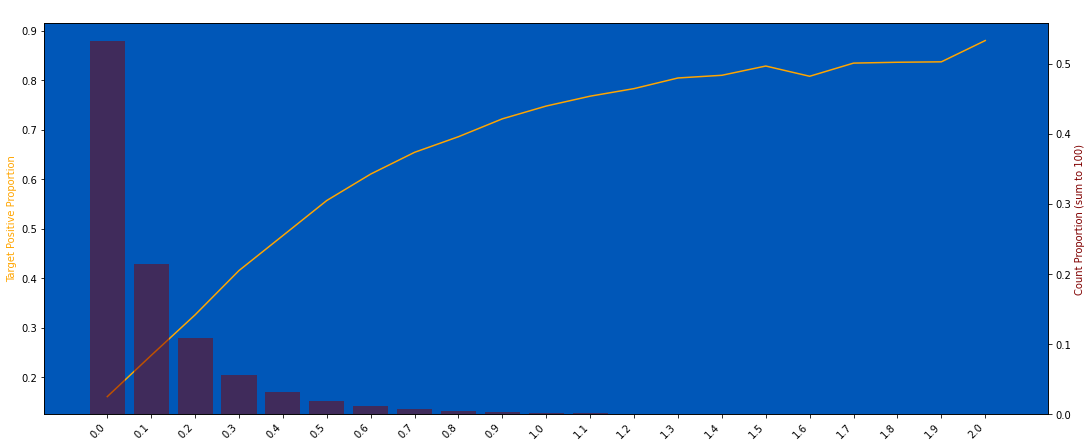

In [30]:
plot_target_check(train, "R_3", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True, without_drop_tail=True)

In [180]:
# plot_train_test_distribution(df_list, "R_3", nunique_thr=100, without_drop_tail=True)

### R_4 (Done Binary)

In [32]:
# plot_target_check(train, "R_4", q=50, use_raw_bin=True)

In [33]:
%%time
df_list = round_dfs(df_list, col="R_4", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0000
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 3.57 s, sys: 1.77 s, total: 5.34 s
Wall time: 7.05 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


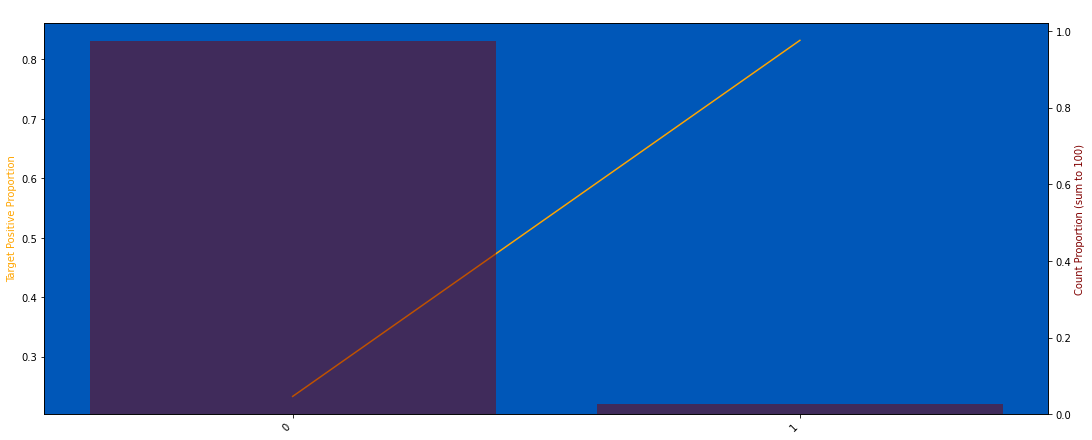

In [181]:
plot_target_check(train, "R_4", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True, without_drop_tail=True)

In [182]:
# plot_train_test_distribution(df_list, "R_4", nunique_thr=100, without_drop_tail=True)

### R_5 (Done Binary)

In [36]:
# plot_target_check(train, "R_5", q=50, use_raw_bin=True, nunique_thr=2)

In [37]:
%%time
df_list = round_dfs(df_list, col="R_5", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0060
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0049
CPU times: user 3.53 s, sys: 1.74 s, total: 5.27 s
Wall time: 6.99 s


In [38]:
# plot_target_check(train, "R_5", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True, without_drop_tail=True)

In [39]:
for df in df_list:
    df["R_5"] *= 2
    df["R_5"] = np.where(df["R_5"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


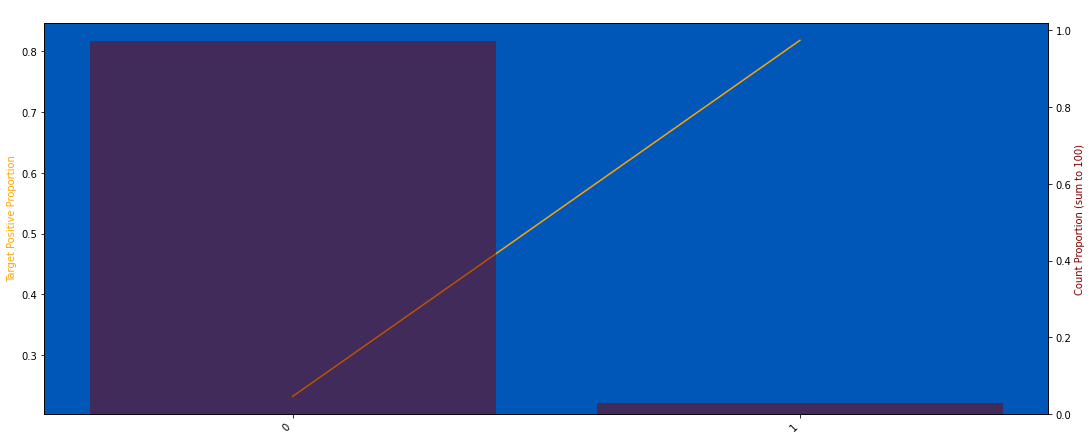

In [40]:
plot_target_check(train, "R_5", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True, without_drop_tail=True)

In [41]:
# plot_train_test_distribution(df_list, "R_5", nunique_thr=100, without_drop_tail=True)

### R_6 (Done Binary)

In [42]:
# plot_target_check(train, "R_6", q=50, use_raw_bin=True)

In [43]:
%%time
df_list = round_dfs(df_list, col="R_6", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0005
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0013
CPU times: user 3.53 s, sys: 1.66 s, total: 5.19 s
Wall time: 6.89 s


In [44]:
for df in df_list:
    df["R_6"] = np.where(df["R_6"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


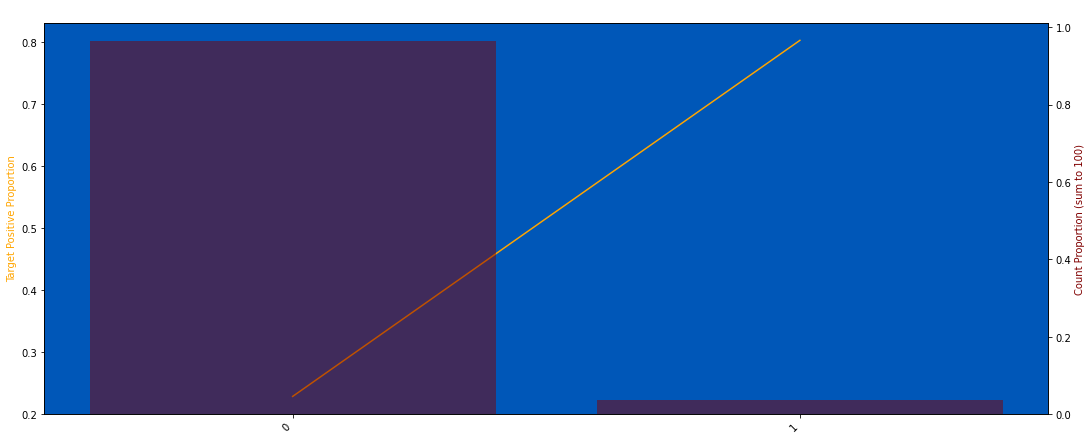

In [45]:
plot_target_check(train, "R_6", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

In [46]:
# plot_train_test_distribution(df_list, "R_6", nunique_thr=5000)

### R_7 (Done Binary)

In [47]:
# plot_target_check(train, "R_7", q=50, use_raw_bin=True, nunique_thr=200, strfy_x=True)

In [48]:
%%time
df_list = round_dfs(df_list, col="R_7", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0889
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0889
CPU times: user 3.56 s, sys: 1.76 s, total: 5.32 s
Wall time: 7.1 s


In [49]:
for df in df_list:
    df["R_7"] = np.where(df["R_7"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


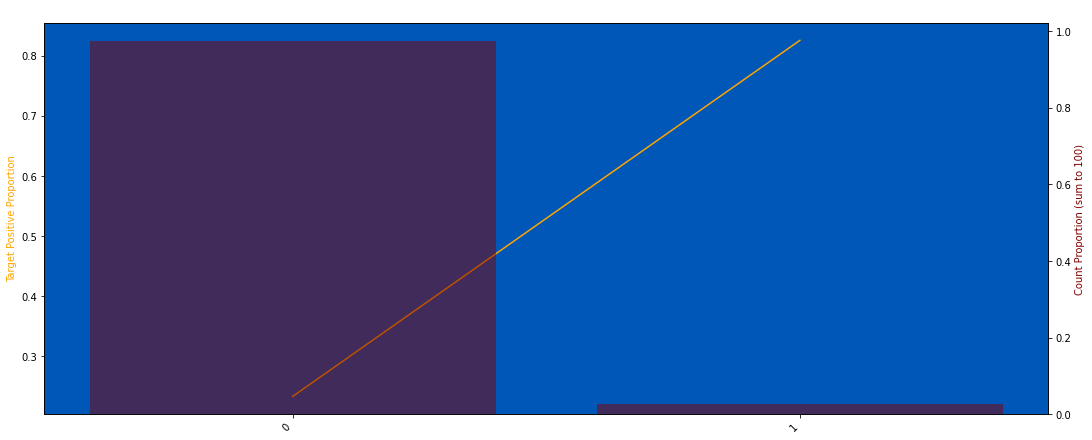

In [50]:
plot_target_check(train, "R_7", q=50, use_raw_bin=True, nunique_thr=20000, strfy_x=True)

In [51]:
# plot_train_test_distribution(df_list, "R_7", nunique_thr=20000)

### R_8 (Done Binary)

In [52]:
# plot_target_check(train, "R_8", q=50, use_raw_bin=True)

In [53]:
%%time
df_list = round_dfs(df_list, col="R_8", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0055
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0050
CPU times: user 3.42 s, sys: 1.61 s, total: 5.03 s
Wall time: 6.78 s


In [54]:
for df in df_list:
    df["R_8"] = np.where(df["R_8"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


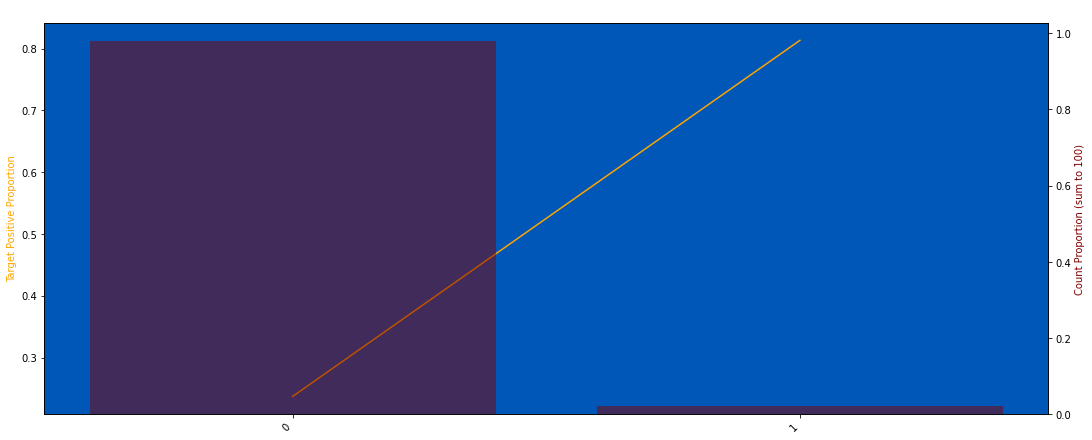

In [55]:
plot_target_check(train, "R_8", q=50, use_raw_bin=True, nunique_thr=30000, strfy_x=True, without_drop_tail=True)

In [56]:
# plot_train_test_distribution(df_list, "R_8", nunique_thr=100, without_drop_tail=True)

### R_9 (Done Integer)

In [57]:
# plot_target_check(train, "R_9", q=50, use_raw_bin=True)

In [58]:
%%time
df_list = round_dfs(df_list, col="R_9", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0073
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0170
CPU times: user 2.51 s, sys: 1.63 s, total: 4.14 s
Wall time: 6.45 s


In [59]:
for df in df_list:
    df["R_9"] = (df["R_9"] / 0.167).round(0)
    df["R_9"] = df["R_9"].replace(0, 1)

In [184]:
print_percentile(df_list, "R_9", 99.9)

99.9th percentile:
train : 5.0
public test : 5.0
private test : 5.0


In [185]:
for df in df_list:
    df = clip_col(df, "R_9", top_value=5, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


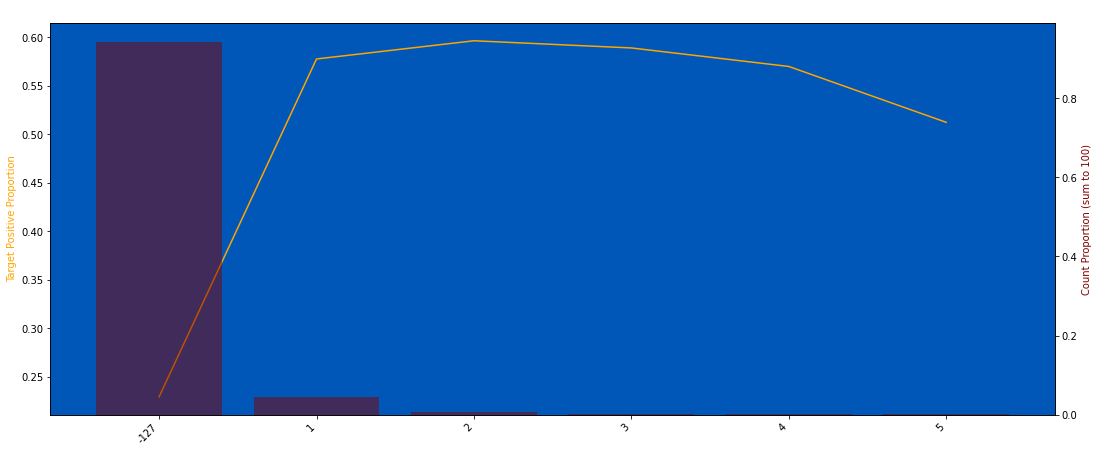

In [186]:
plot_target_check(train, "R_9", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [188]:
# plot_train_test_distribution(df_list, "R_9", nunique_thr=100, without_drop_tail=True)

### R_10 (Done Binary)

In [62]:
# plot_target_check(train, "R_10", q=50, use_raw_bin=True)

In [63]:
%%time
df_list = round_dfs(df_list, col="R_10", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0029
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0029
CPU times: user 3.31 s, sys: 1.54 s, total: 4.85 s
Wall time: 6.55 s


In [64]:
for df in df_list:
    df["R_10"] = np.where(df["R_10"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


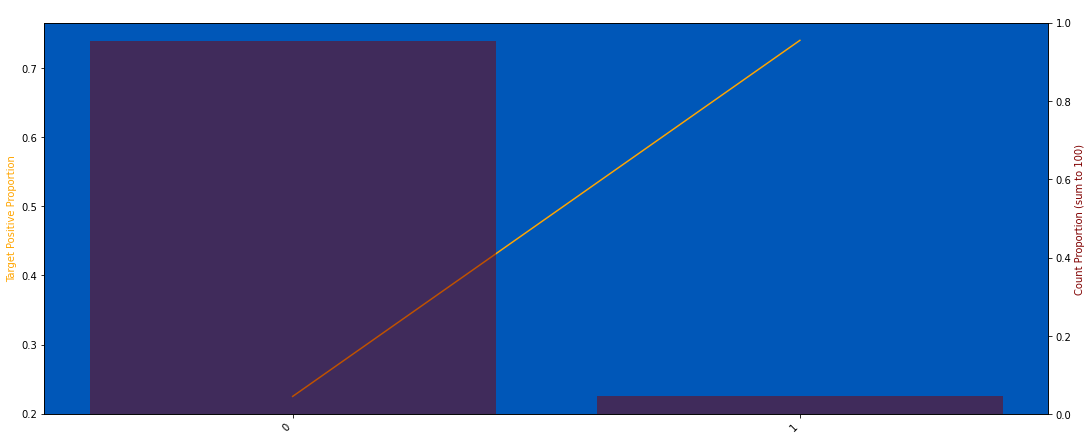

In [65]:
plot_target_check(train, "R_10", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [66]:
# plot_train_test_distribution(df_list, "R_10", nunique_thr=100, without_drop_tail=True)

### R_11 (Done Integer)

In [67]:
# plot_target_check(train, "R_11", q=50, use_raw_bin=True)

In [68]:
%%time
df_list = round_dfs(df_list, col="R_11", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0059
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0034
CPU times: user 3.3 s, sys: 1.48 s, total: 4.78 s
Wall time: 6.5 s


In [69]:
for df in df_list:
    df["R_11"] = (df["R_11"] * 2).round(0)

In [70]:
describe_all(df_list, "R_11")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0917,0.0871,0.0857
std,0.3512,0.3416,0.3387
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,25.0000,17.0000,62.0000
null_proportion,0.0000,0.0000,0.0000


In [191]:
print_percentile(df_list, "R_11", 99.96)

99.96th percentile:
train : 4.0
public test : 4.0
private test : 4.0


In [192]:
for df in df_list:
    df = clip_col(df, "R_11", top_value=4, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


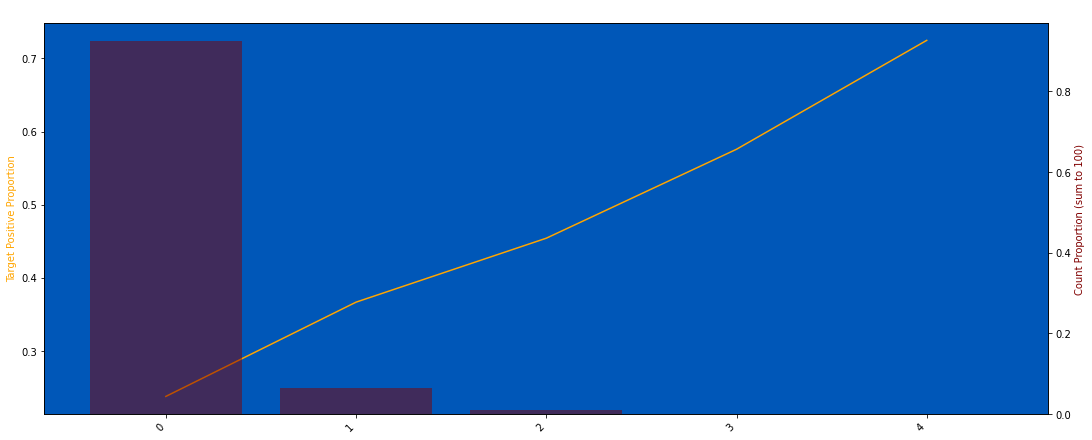

In [193]:
plot_target_check(train, "R_11", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [74]:
# plot_train_test_distribution(df_list, "R_11", nunique_thr=100, without_drop_tail=True)

### R_12 (Done Binary)

In [75]:
# plot_target_check(train, "R_12", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1000)

In [76]:
%%time
df_list = round_dfs(df_list, col="R_12", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0620
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0095
CPU times: user 3.27 s, sys: 1.5 s, total: 4.77 s
Wall time: 6.48 s


In [77]:
for df in df_list:
    df["R_12"] = np.where(df["R_12"] < 1, 0, 1)

0 null count, 0.000 null proportion
nan of the targets have label = 1


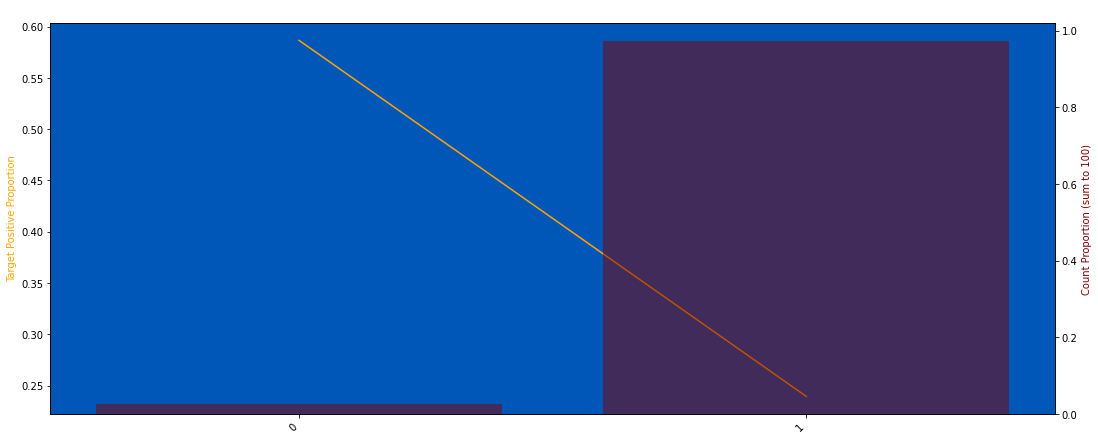

In [78]:
plot_target_check(train, "R_12", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1000, without_drop_tail=True)

In [79]:
# plot_train_test_distribution(df_list, "R_12", nunique_thr=100, without_drop_tail=True)

### R_13 (Done Binary)

In [80]:
# plot_target_check(train, "R_13", q=50, use_raw_bin=True, nunique_thr=29, strfy_x=True)

In [81]:
%%time
df_list = round_dfs(df_list, col="R_13", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0311
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0056
CPU times: user 3.2 s, sys: 1.47 s, total: 4.68 s
Wall time: 6.41 s


In [82]:
for df in df_list:
    df["R_13"] = np.where(df["R_13"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


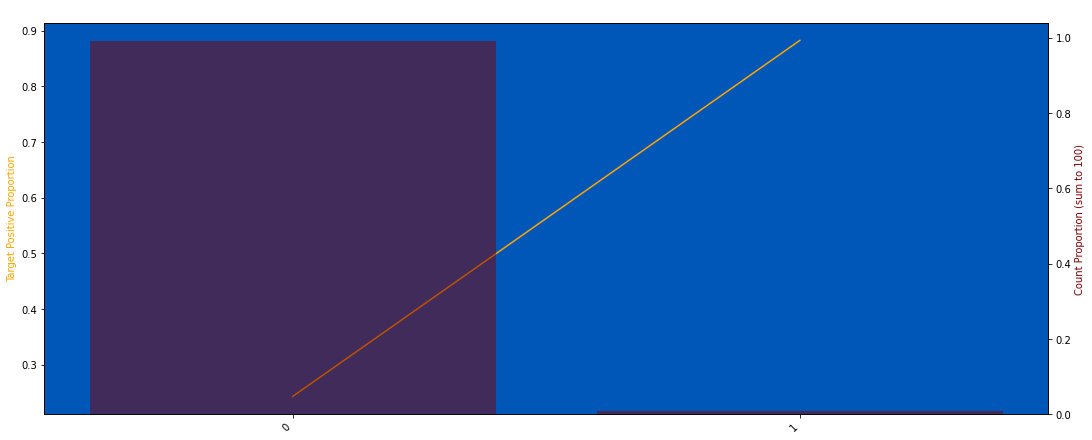

In [83]:
plot_target_check(train, "R_13", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [84]:
# plot_train_test_distribution(df_list, "R_13", nunique_thr=100, without_drop_tail=True)

### R_14 (Done Binary)

In [85]:
# plot_target_check(train, "R_14", q=50, use_raw_bin=True)

In [86]:
%%time
df_list = round_dfs(df_list, col="R_14", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0605
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0605
CPU times: user 3.15 s, sys: 1.43 s, total: 4.58 s
Wall time: 6.3 s


In [87]:
for df in df_list:
    df["R_14"] = np.where(df["R_14"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


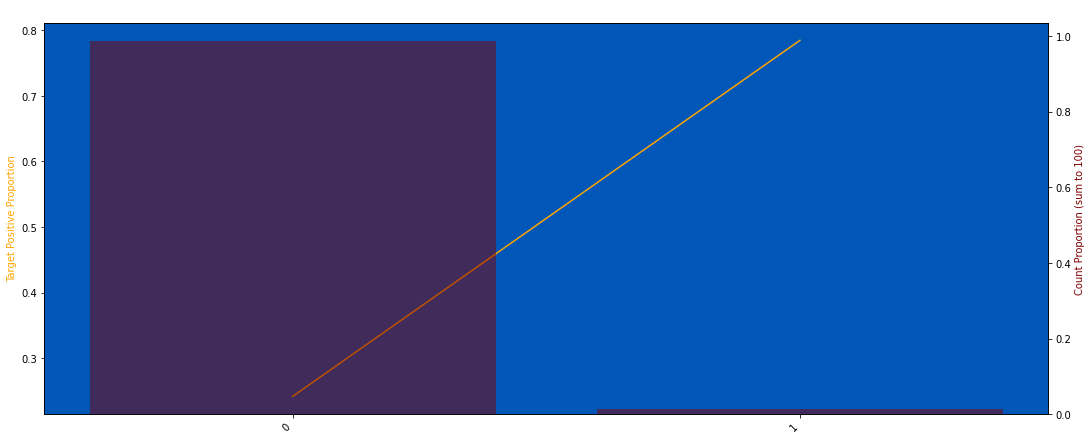

In [88]:
plot_target_check(train, "R_14", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [89]:
# plot_train_test_distribution(df_list, "R_14", nunique_thr=50000, without_drop_tail=True)

### R_15 (Done Binary)

In [90]:
# plot_target_check(train, "R_15", q=50, use_raw_bin=True)

In [91]:
%%time
df_list = round_dfs(df_list, col="R_15", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0002
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0002
CPU times: user 3.11 s, sys: 1.36 s, total: 4.48 s
Wall time: 6.17 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


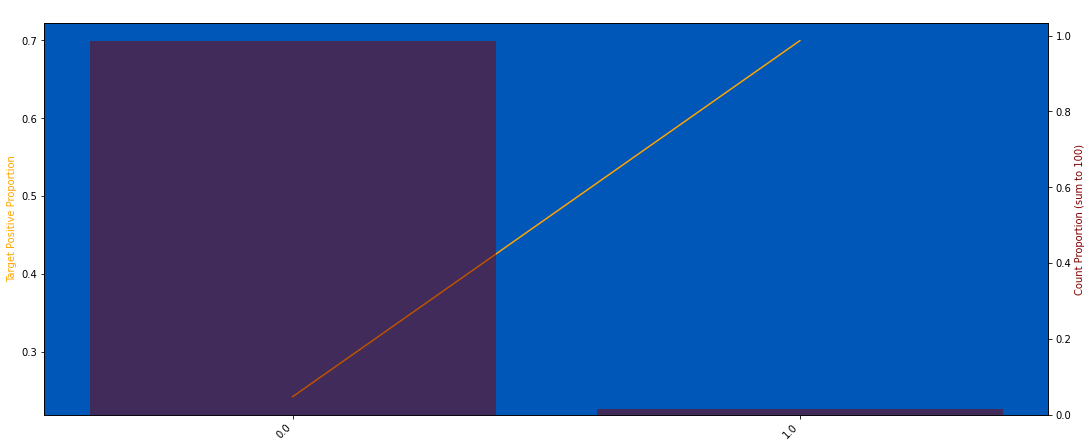

In [92]:
plot_target_check(train, "R_15", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

In [93]:
# plot_train_test_distribution(df_list, "R_15", nunique_thr=50000, without_drop_tail=True)

### R_16 (Done Integer)

In [94]:
# plot_target_check(train, "R_16", q=50, use_raw_bin=True)

In [95]:
%%time
df_list = round_dfs(df_list, col="R_16", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0093
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0038
CPU times: user 3.24 s, sys: 1.45 s, total: 4.69 s
Wall time: 6.42 s


In [96]:
for df in df_list:
    df["R_16"] *= 2

In [97]:
describe_all(df_list, "R_16")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1071,0.1111,0.1041
std,0.4785,0.4887,0.4667
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,37.0000,40.0000,33.0000
null_proportion,0.0000,0.0000,0.0000


In [195]:
print_percentile(df_list, "R_16", 99.8)

99.8th percentile:
train : 4.0
public test : 4.0
private test : 4.0


In [196]:
for df in df_list:
    df = clip_col(df, "R_16", top_value=4, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


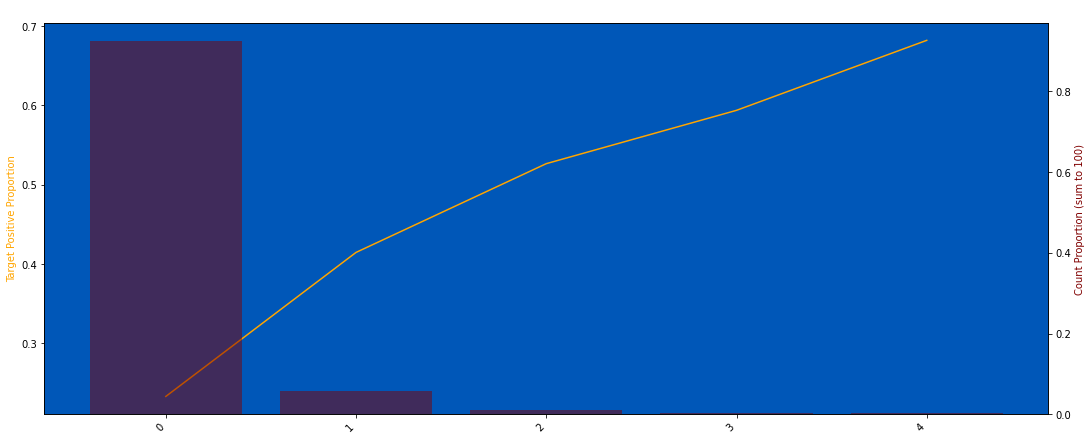

In [197]:
plot_target_check(train, "R_16", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [201]:
# plot_train_test_distribution(df_list, "R_16", nunique_thr=50000, without_drop_tail=True)

### R_17 (Done Binary)

In [102]:
# plot_target_check(train, "R_17", q=50, use_raw_bin=True, nunique_thr=26)

In [103]:
%%time
df_list = round_dfs(df_list, col="R_17", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0205
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0006
CPU times: user 3.08 s, sys: 1.34 s, total: 4.42 s
Wall time: 6.14 s


In [104]:
for df in df_list:
    df["R_17"] = np.where(df["R_17"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


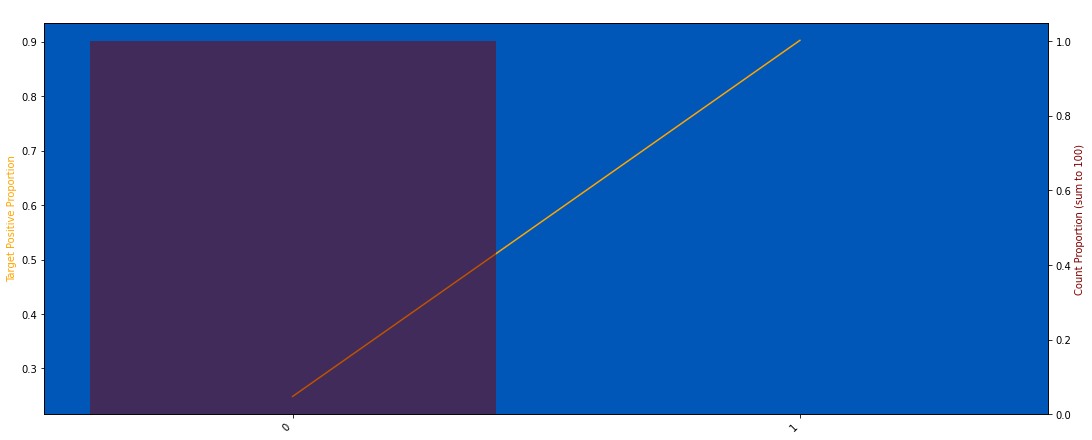

In [105]:
plot_target_check(train, "R_17", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [200]:
# plot_train_test_distribution(df_list, "R_17", nunique_thr=50000, without_drop_tail=True)

### R_18 (Done Binary)

In [107]:
# plot_target_check(train, "R_18", q=50, use_raw_bin=True)

In [108]:
%%time
df_list = round_dfs(df_list, col="R_18", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0347
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0052
CPU times: user 3.04 s, sys: 1.32 s, total: 4.36 s
Wall time: 6.08 s


In [109]:
for df in df_list:
    df["R_18"] = np.where(df["R_18"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


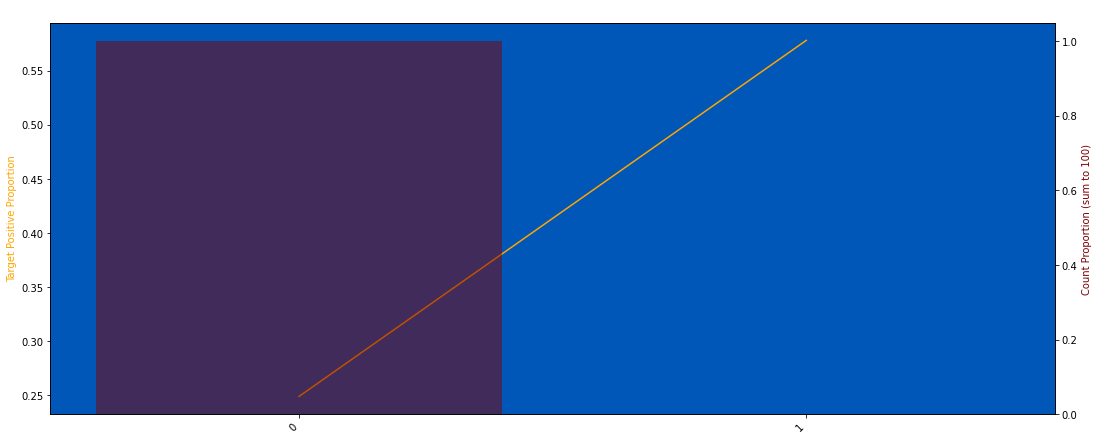

In [110]:
plot_target_check(train, "R_18", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [199]:
# plot_train_test_distribution(df_list, "R_18", nunique_thr=50000, without_drop_tail=True)

### R_19 (Done Binary)

In [112]:
# plot_target_check(train, "R_19", q=50, use_raw_bin=True, nunique_thr=20)

In [113]:
%%time
df_list = round_dfs(df_list, col="R_19", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0003
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0003
CPU times: user 3.04 s, sys: 1.3 s, total: 4.33 s
Wall time: 6.1 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


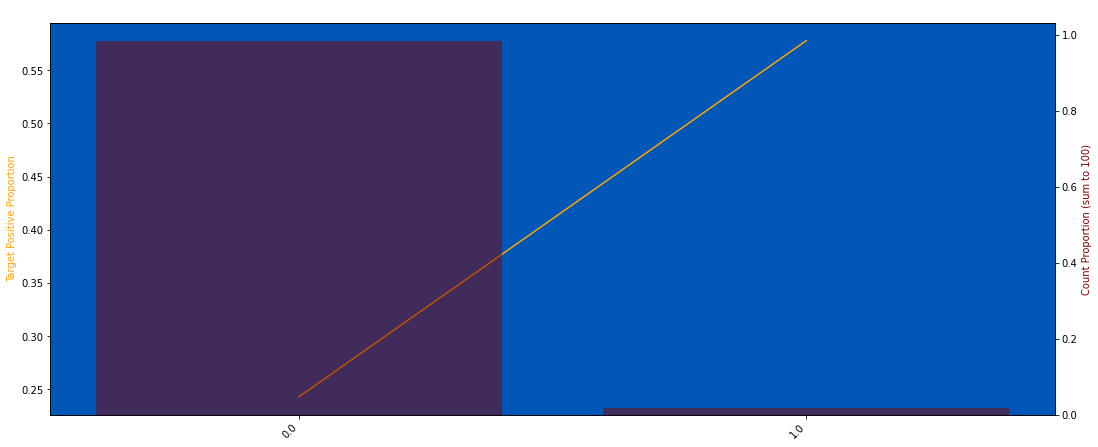

In [114]:
plot_target_check(train, "R_19", q=50, use_raw_bin=True, nunique_thr=4, strfy_x=True, without_drop_tail=True)

In [115]:
# plot_train_test_distribution(df_list, "R_19", nunique_thr=500, without_drop_tail=True)

### R_20 (Done Binary)

In [116]:
# plot_target_check(train, "R_20", q=50, use_raw_bin=True)

In [117]:
%%time
df_list = round_dfs(df_list, col="R_20", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0030
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0024
CPU times: user 3.02 s, sys: 1.27 s, total: 4.29 s
Wall time: 6 s


In [118]:
for df in df_list:
    df["R_20"] = np.where(df["R_20"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


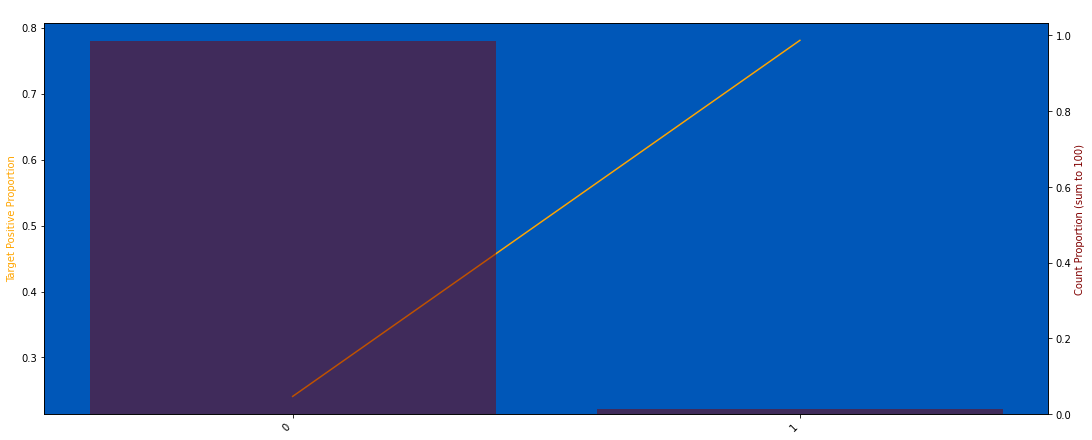

In [119]:
plot_target_check(train, "R_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [120]:
# plot_train_test_distribution(df_list, "R_20", nunique_thr=500, without_drop_tail=True)

### R_21 (Done Binary)

In [121]:
# plot_target_check(train, "R_21", q=50, use_raw_bin=True)

In [122]:
%%time
df_list = round_dfs(df_list, col="R_21", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0008
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0008
CPU times: user 2.93 s, sys: 1.23 s, total: 4.16 s
Wall time: 5.85 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


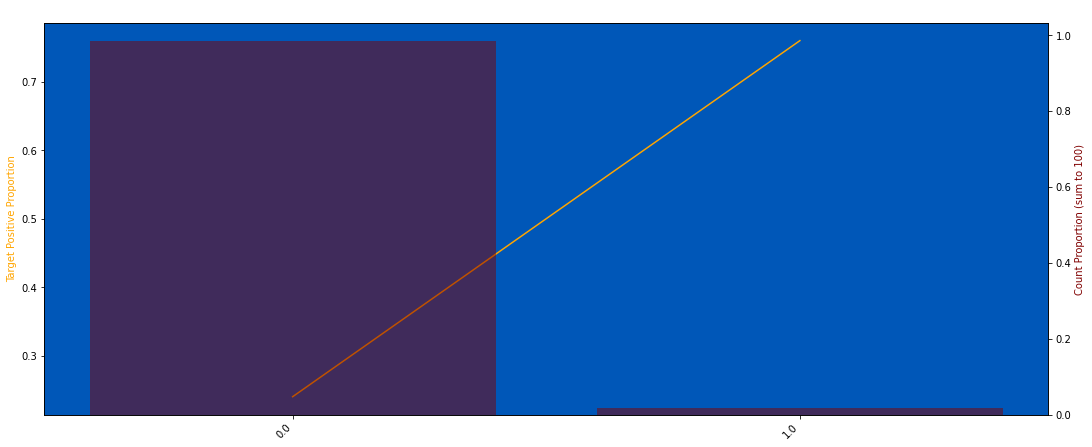

In [123]:
plot_target_check(train, "R_21", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [124]:
# plot_train_test_distribution(df_list, "R_21", nunique_thr=500, without_drop_tail=True)

### R_22 (Done Binary)

In [125]:
# plot_target_check(train, "R_22", q=50, use_raw_bin=True)

In [126]:
%%time
df_list = round_dfs(df_list, col="R_22", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0001
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0001
CPU times: user 2.88 s, sys: 1.21 s, total: 4.08 s
Wall time: 5.75 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


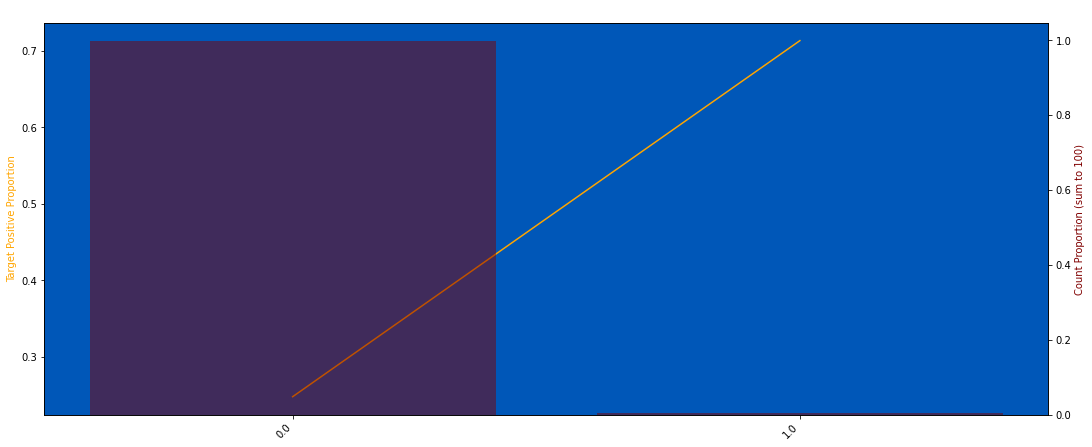

In [127]:
plot_target_check(train, "R_22", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [128]:
# plot_train_test_distribution(df_list, "R_22", nunique_thr=500, without_drop_tail=True)

### R_23 (Done Binary)

In [129]:
# plot_target_check(train, "R_23", q=50, use_raw_bin=True)

In [130]:
%%time
df_list = round_dfs(df_list, col="R_23", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0007
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0007
CPU times: user 2.89 s, sys: 1.19 s, total: 4.07 s
Wall time: 5.75 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


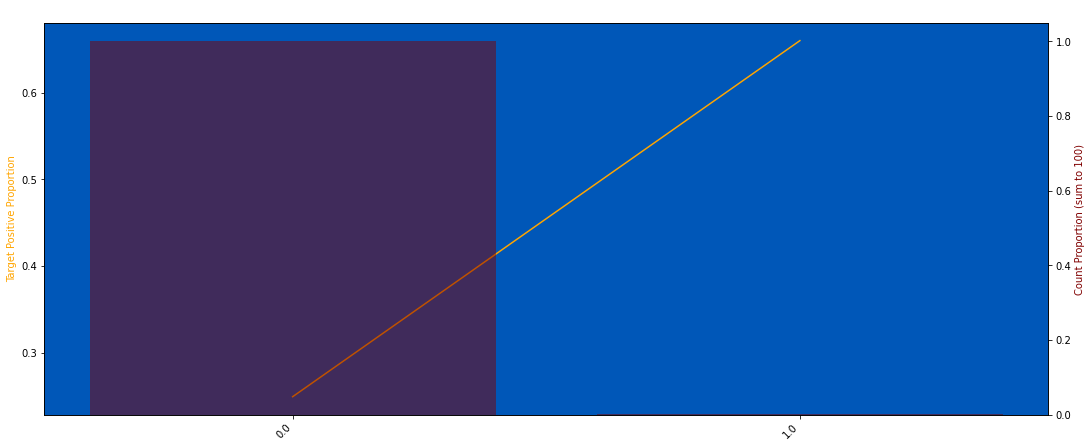

In [131]:
plot_target_check(train, "R_23", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [132]:
# plot_train_test_distribution(df_list, "R_23", nunique_thr=500, without_drop_tail=True)

### R_24 (Done Binary)

In [133]:
# plot_target_check(train, "R_24", q=50, use_raw_bin=True)

In [134]:
%%time
df_list = round_dfs(df_list, col="R_24", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0000
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 2.9 s, sys: 1.18 s, total: 4.09 s
Wall time: 5.78 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


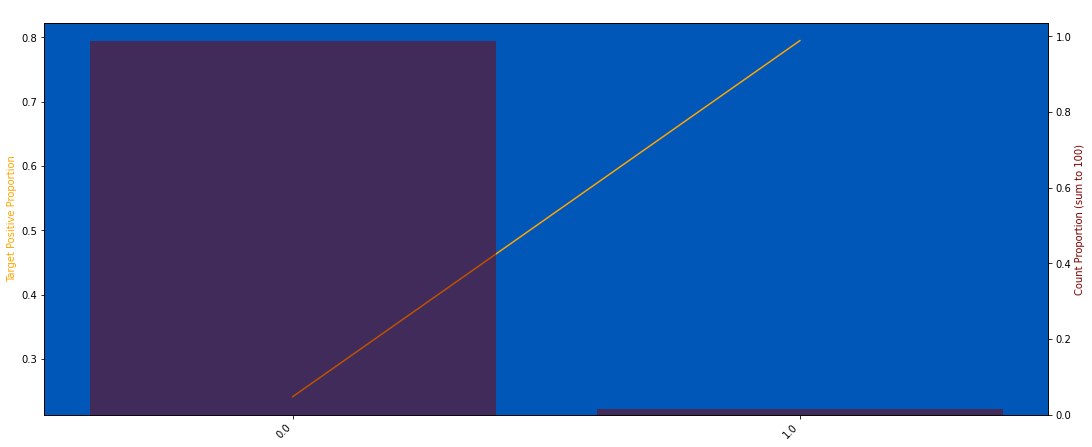

In [135]:
plot_target_check(train, "R_24", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [136]:
# plot_train_test_distribution(df_list, "R_24", nunique_thr=500, without_drop_tail=True)

### R_25 (Done Binary)

In [137]:
# plot_target_check(train, "R_25", q=50, use_raw_bin=True)

In [138]:
%%time
df_list = round_dfs(df_list, col="R_25", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0001
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0001
CPU times: user 2.8 s, sys: 1.11 s, total: 3.91 s
Wall time: 5.64 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


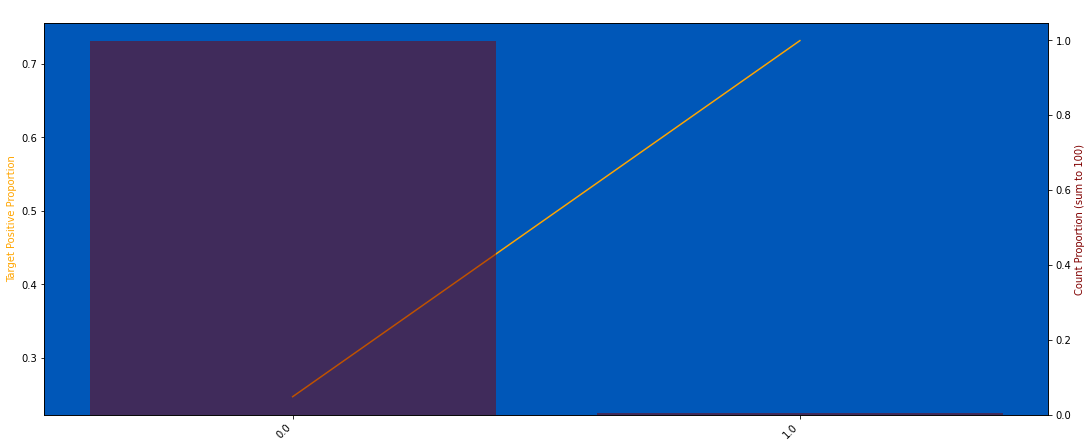

In [139]:
plot_target_check(train, "R_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [140]:
# plot_train_test_distribution(df_list, "R_25", nunique_thr=500, without_drop_tail=True)

### R_26 (Done Binary)

In [141]:
# plot_target_check(train, "R_26", q=50, use_raw_bin=True)

In [142]:
%%time
df_list = round_dfs(df_list, col="R_26", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0878
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0810
CPU times: user 1.97 s, sys: 1.09 s, total: 3.05 s
Wall time: 5.14 s


In [143]:
for df in df_list:
    df["R_26"] = np.where(df["R_26"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


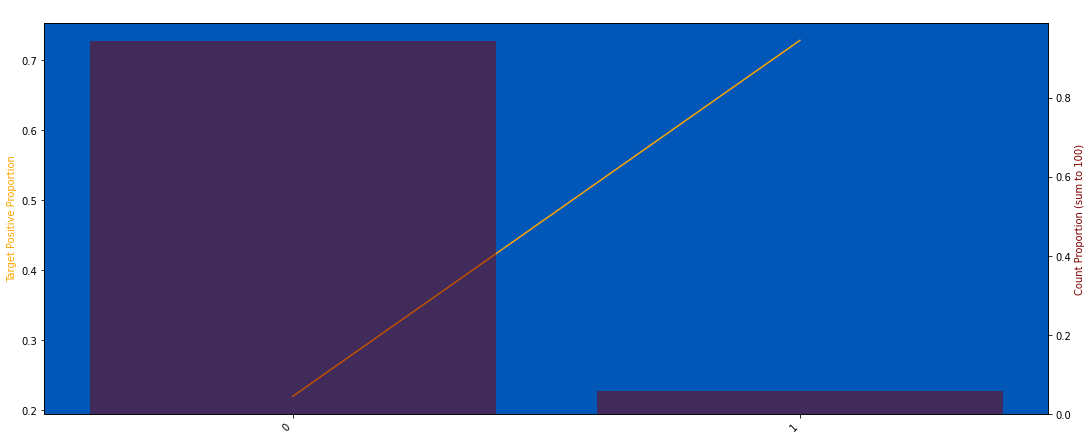

In [144]:
plot_target_check(train, "R_26", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True)

In [145]:
# plot_train_test_distribution(df_list, "R_26", nunique_thr=5000)

### R_27 (Done Binary)

In [146]:
# plot_target_check(train, "R_27", q=50, use_raw_bin=True, strfy_x=True)

In [147]:
%%time
df_list = round_dfs(df_list, col="R_27", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0181
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0162
CPU times: user 2.75 s, sys: 1.04 s, total: 3.79 s
Wall time: 5.55 s


In [148]:
for df in df_list:
    df["R_27"] = np.where(df["R_27"] >= 0.9, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


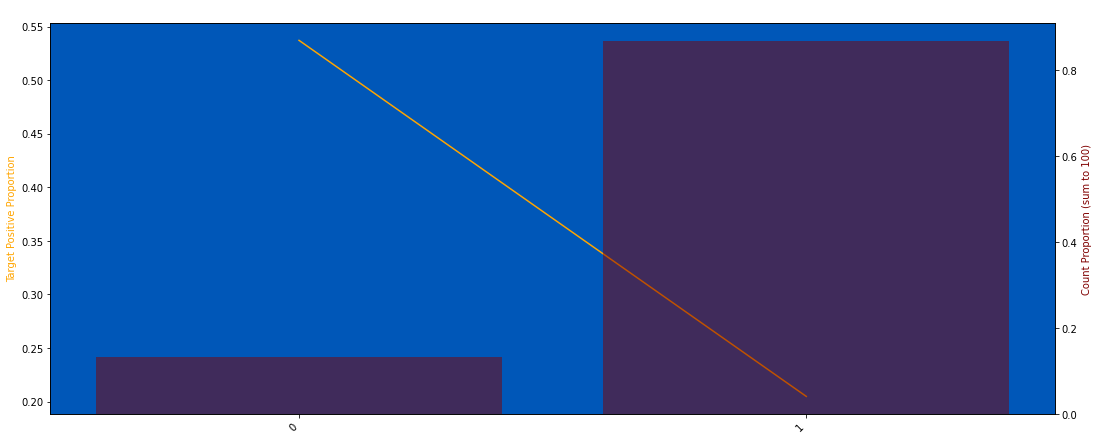

In [149]:
plot_target_check(train, "R_27", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [202]:
# plot_train_test_distribution(df_list, "R_27", nunique_thr=5000, without_drop_tail=True)

### R_28 (Done Binary)

In [151]:
# plot_target_check(train, "R_28", q=50, use_raw_bin=True)

In [152]:
%%time
df_list = round_dfs(df_list, col="R_28", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0000
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 2.66 s, sys: 1.03 s, total: 3.69 s
Wall time: 5.37 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


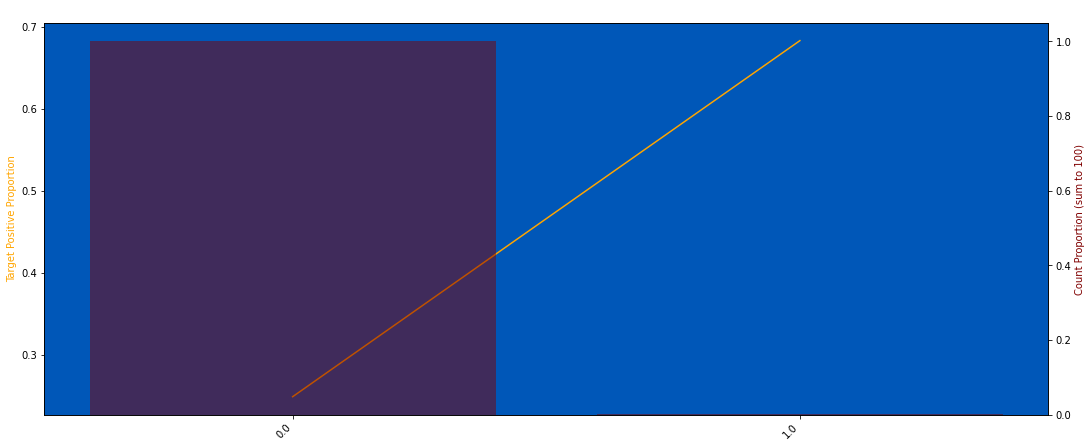

In [153]:
plot_target_check(train, "R_28", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [154]:
# plot_train_test_distribution(df_list, "R_28", nunique_thr=5000, without_drop_tail=True)

### Column checking

In [155]:
all_columns = get_cols(df_list[0], ["R_"])
print(all_columns)

['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28']


In [156]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()

In [157]:
print(less_unique_d_cols)

['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28']


In [158]:
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

R_1 fulfill criteria to convert to integer
R_2 fulfill criteria to convert to integer
R_4 fulfill criteria to convert to integer
R_5 fulfill criteria to convert to integer
R_6 fulfill criteria to convert to integer
R_7 fulfill criteria to convert to integer
R_8 fulfill criteria to convert to integer
R_9 fulfill criteria to convert to integer
R_10 fulfill criteria to convert to integer
R_11 fulfill criteria to convert to integer
R_12 fulfill criteria to convert to integer
R_13 fulfill criteria to convert to integer
R_14 fulfill criteria to convert to integer
R_15 fulfill criteria to convert to integer
R_16 fulfill criteria to convert to integer
R_17 fulfill criteria to convert to integer
R_18 fulfill criteria to convert to integer
R_19 fulfill criteria to convert to integer
R_20 fulfill criteria to convert to integer
R_21 fulfill criteria to convert to integer
R_22 fulfill criteria to convert to integer
R_23 fulfill criteria to convert to integer
R_24 fulfill criteria to convert to inte

In [159]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

R_3 fulfill criteria to convert to float32
temp fulfill criteria to convert to float32


In [160]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [161]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

CPU times: user 2.14 s, sys: 1.85 s, total: 3.98 s
Wall time: 3.98 s


### Verify if all columns have been clipped

In [203]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if not (df_list[0][col].min() == df_list[1][col].min() == df_list[2][col].min()):
        print(f"Min of column {col} is different: {df_list[0][col].min()}, {df_list[1][col].min()}, {df_list[2][col].min()}")
    
    if not (df_list[0][col].max() == df_list[1][col].max() == df_list[2][col].max()):
        print(f"Max of column {col} is different: {df_list[0][col].max()}, {df_list[1][col].max()}, {df_list[2][col].max()}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.91it/s]


In [ ]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

In [ ]:
train.shape, test.shape

In [ ]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

In [ ]:
%%time
train.to_parquet(f"./train_parquet/train_risk_.parquet")
test.to_parquet(f"./test_parquet/test_risk_.parquet")

In [ ]:
END = time.time()

In [ ]:
print(f"{END - START:.2f} seconds elapsed")